# Tutorial: Pendulum data with MLP

In [4]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import tutorial_ddd
import tutorial_ddd.lorenz
%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Epoch 0, Loss: 469.417725
Epoch 50, Loss: 437.795441
Epoch 100, Loss: 405.383270
Epoch 150, Loss: 370.988647
Epoch 200, Loss: 335.222565
Epoch 250, Loss: 298.444153
Epoch 300, Loss: 261.644470
Epoch 350, Loss: 225.814072
Epoch 400, Loss: 191.849014
Epoch 450, Loss: 160.989319
Epoch 500, Loss: 134.329971
Epoch 550, Loss: 112.621490
Epoch 600, Loss: 95.965141
Epoch 650, Loss: 83.953522
Epoch 700, Loss: 75.776672
Epoch 750, Loss: 70.460426
Epoch 800, Loss: 67.128044
Epoch 850, Loss: 65.039688
Epoch 900, Loss: 63.675781
Epoch 950, Loss: 62.654625
Epoch 1000, Loss: 61.852325
Epoch 1050, Loss: 61.164768
Epoch 1100, Loss: 60.532612
Epoch 1150, Loss: 59.924149
Epoch 1200, Loss: 59.332474
Epoch 1250, Loss: 58.755409
Epoch 1300, Loss: 58.182713
Epoch 1350, Loss: 57.610428
Epoch 1400, Loss: 57.036205
Epoch 1450, Loss: 56.460072
Epoch 1500, Loss: 55.875072
Epoch 1550, Loss: 55.269890
Epoch 1600, Loss: 54.615917
Epoch 1650, Loss: 53.977512
Epoch 1700, Loss: 53.356205
Epoch 1750, Loss: 52.736095
Epo

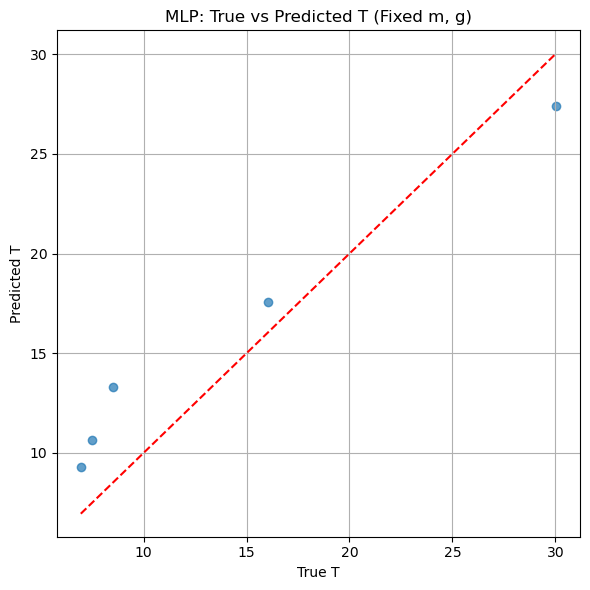

In [3]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# Import your MLP class
from tutorial_ddd.models import MLP  

# Fix seed for reproducibility
torch.manual_seed(701)

# ---------- Load dataset ----------
def load_fixed_mg_dataset(noisy=True):
    fname = "fixed_mg_noisy.dat" if noisy else "fixed_mg_noiseless.dat"
    path = Path("pysr_with_data/updated_data") / fname
    with open(path, "r") as f:
        lines = [line for line in f if not line.startswith("#")]
    data = np.loadtxt(lines)
    X = data[:, :-1]  # m, g, L, j
    y = data[:, -1:]  # T (as column vector)
    return X, y

# Load dataset
X, y = load_fixed_mg_dataset(noisy=False)

# ---------- Train-test split ----------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=701)

# ---------- Torch setup ----------
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).float()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).float()

train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# ---------- Define model ----------
input_size = X.shape[1]
output_size = y.shape[1]
model = MLP(ndim=32, nlayers=1, input_size=input_size, output_size=output_size)

# ---------- Loss and optimizer ----------
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1.0)

# ---------- Training loop ----------
num_epochs = 5000
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        pred = model(batch_X)
        loss = loss_fn(pred, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(train_loader.dataset)
    losses.append(epoch_loss)
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {epoch_loss:.6f}")

# ---------- Evaluate ----------
model.eval()
with torch.no_grad():
    pred_test = model(X_test_t)
    test_loss = loss_fn(pred_test, y_test_t).item()
    print(f"\nFinal Test MSE Loss: {test_loss:.6f}")

# ---------- Plot true vs predicted ----------
plt.figure(figsize=(6, 6))
plt.scatter(y_test, pred_test.numpy(), alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True T")
plt.ylabel("Predicted T")
plt.title("MLP: True vs Predicted T (Fixed m, g)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [17]:
import math

# Your custom input: m=10, g=5, L=40, j=3
custom_input = np.array([[10.0, 5.0, 40.0, 3.0]], dtype=np.float32)  # shape (1, 4)
custom_tensor = torch.from_numpy(custom_input)

# Predict using trained model
model.eval()
with torch.no_grad():
    prediction = model(custom_tensor).item()

# Ground truth using formula: T = 2*pi*sqrt(L/g)*j
m, g, L, j = custom_input[0]
ground_truth = 2 * math.pi * math.sqrt(L / g) * j

print(f"\nCustom Input: m={m}, g={g}, L={L}, j={j}")
print(f"Predicted T from model: {prediction:.6f}")
print(f"Ground truth T:         {ground_truth:.6f}")
print(f"Absolute error:         {abs(prediction - ground_truth):.6f}")


Custom Input: m=10.0, g=5.0, L=40.0, j=3.0
Predicted T from model: 44.476116
Ground truth T:         53.314598
Absolute error:         8.838482
